In [ ]:
import pandas as pd
import scanpy as sc
from pathlib import Path

# ---- paths ----
P = Path("/Users/juliachen/Documents/AI4bio/UMAP/tumors/processed/finaltables")
COUNTS_CSV = "matched_merfishcounttable_xy.csv"     # counts matrix
PERT_MATRIX_CSV = P / "tumorpooledperturbations.csv"    # perturbation annotations

# ---- load counts ----
df = pd.read_csv(COUNTS_CSV)
assert {"cell_id","X","Y"}.issubset(df.columns)

num_cols = [c for c in df.columns if c not in {"cell_id","X","Y"}]
adata = sc.AnnData(df[num_cols].to_numpy())
adata.obs_names = df["cell_id"].astype(str).values
adata.var_names = num_cols
adata.obs["X"] = df["X"].values
adata.obs["Y"] = df["Y"].values
adata.layers["count"] = adata.X.copy()

print("adata shape:", adata.shape)

# ---- load pooled perturbation matrix ----
pm = pd.read_csv(PERT_MATRIX_CSV, index_col=0).apply(pd.to_numeric, errors="coerce").fillna(0.0)
print("pm shape:", pm.shape)

adata shape: (9432, 500)
pm shape: (36, 9432)


In [ ]:
cond_counts = adata.obs["condition"].value_counts()
print("Control:", cond_counts.get("control", 0))
print("Treated:", cond_counts.get("treated", 0))
print("Fractions:", (cond_counts / cond_counts.sum()).round(3).to_dict())
import numpy as np                          

Control: 4398
Treated: 5034
Fractions: {'treated': 0.534, 'control': 0.466}


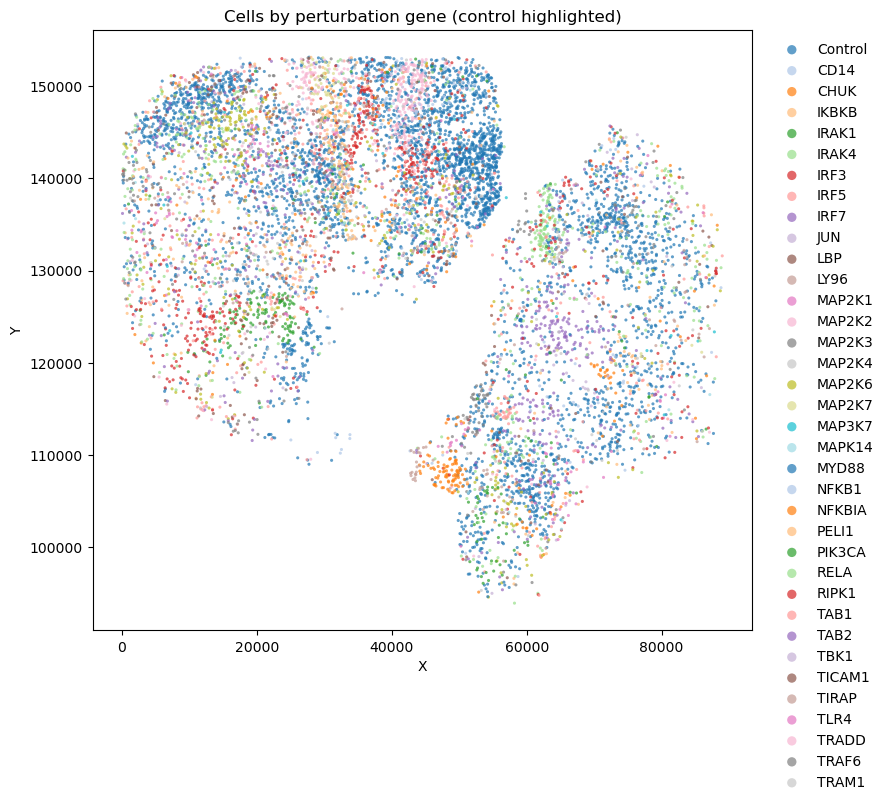

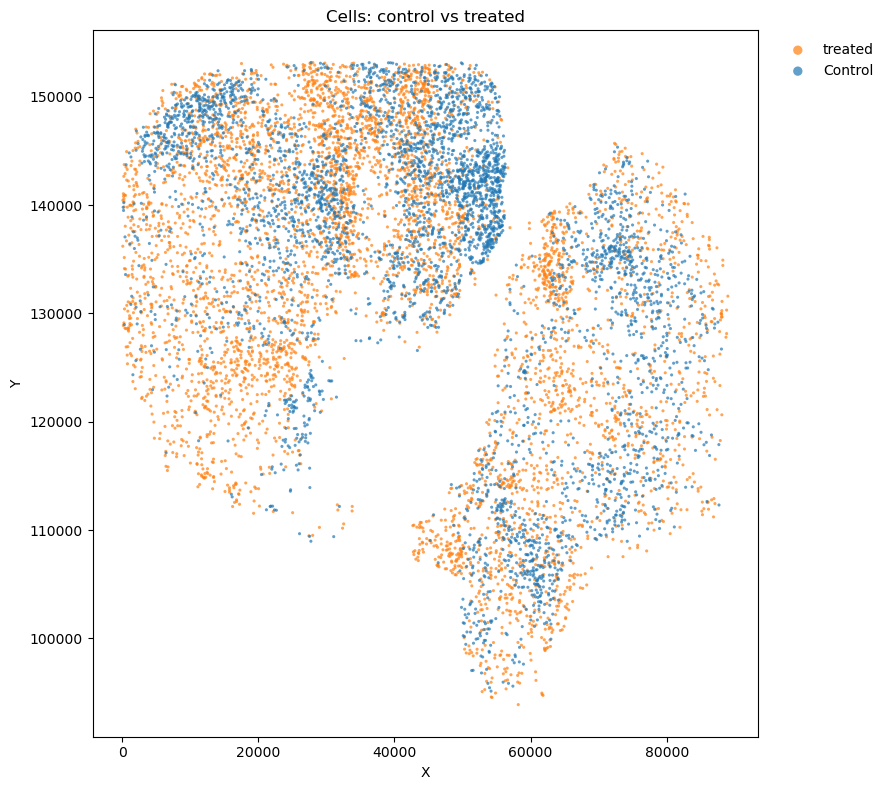

In [ ]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# ---------- load ----------
P = Path("/Users/juliachen/Documents/AI4bio/UMAP/tumors/processed/finaltables")
counts  = pd.read_csv( "matched_merfishcounttable_xy.csv")   # expects: cell_id, X, Y
perturb = pd.read_csv(P / "tumorpooledperturbations.csv", index_col=0)

# ---------- normalize ids ----------
counts["cell_id"] = counts["cell_id"].astype(str).str.strip().str.upper()
perturb.columns   = perturb.columns.astype(str).str.strip().str.upper()
perturb.index     = perturb.index.astype(str).str.strip()

# ---------- cell -> gene ----------
def label_for_cell(cid: str) -> str:
    if cid not in perturb.columns:
        return "unknown"
    col = perturb[cid]
    nz = col[col > 0]
    if len(nz):
        return nz.index[0]     # or: col.idxmax()
    return "Control"

counts["perturb_gene"] = counts["cell_id"].map(label_for_cell)

# keep known genes + control
valid_genes = set(perturb.index.tolist()) | {"Control"}
plot_df = counts[counts["perturb_gene"].isin(valid_genes)].copy()

# ---------- figure 1: per-gene ----------
genes_other = sorted([g for g in plot_df["perturb_gene"].unique() if g != "Control"])
genes = ["Control"] + genes_other  # control first in legend
palette = cycle(plt.cm.tab20.colors)
color_map = {g: next(palette) for g in genes}

plt.figure(figsize=(9, 8))
for g in genes:
    sub = plot_df.loc[plot_df["perturb_gene"] == g, ["X", "Y"]]
    if not sub.empty:
        plt.scatter(sub["X"], sub["Y"], s=5, alpha=0.7, color=color_map[g], label=g, edgecolors="none")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cells by perturbation gene (control highlighted)")
plt.legend(frameon=False, markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ---------- figure 2: collapse non-control -> treated ----------
plot_df["treated_flag"] = np.where(plot_df["perturb_gene"] == "Control", "Control", "treated")
bin_colors = {"Control": "tab:blue", "treated": "tab:orange"}

plt.figure(figsize=(9, 8))
for label in ["treated", "Control"]:  # control plotted last so it’s visible
    sub = plot_df.loc[plot_df["treated_flag"] == label, ["X", "Y"]]
    if not sub.empty:
        plt.scatter(sub["X"], sub["Y"], s=5, alpha=0.7, color=bin_colors[label], label=label, edgecolors="none")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cells: control vs treated")
plt.legend(frameon=False, markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Load counts → load perturbations → map cells to control/treated → train ContrastiveVI → embed into latent space → visualize with UMAP.

adata shape: (9432, 500)


/opt/anaconda3/envs/astro-scanpy/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Counts per label: {'control': 4264, 'IRF3': 459, 'IRF5': 410, 'IRAK4': 398, 'IRF7': 330, 'MAP2K2': 325, 'MAP2K6': 311, 'MAP2K3': 247, 'PELI1': 223, 'LBP': 210, 'NFKBIA': 184, 'IRAK1': 179, 'TAB2': 167, 'RELA': 162, 'TRAM1': 156, 'MYD88': 148, 'IKBKB': 139, 'RIPK1': 128, 'TIRAP': 123, 'NFKB1': 113, 'CHUK': 95, 'MAP2K1': 85, 'JUN': 84, 'TLR4': 69, 'MAP2K7': 67, 'PIK3CA': 66, 'TRAF6': 63, 'CD14': 40, 'LY96': 33, 'TICAM1': 30, 'MAP3K7': 30, 'TRADD': 29, 'TBK1': 22, 'TAB1': 21, 'MAPK14': 20, 'MAP2K4': 2}
Control=4264, Treated(total across genes)=5168, Total=9432
Training with balanced sets: control=4264 vs treated=4264


/opt/anaconda3/envs/astro-scanpy/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/envs/astro-scanpy/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/astro-scanpy/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 585.188. Signaling Trainer to stop.


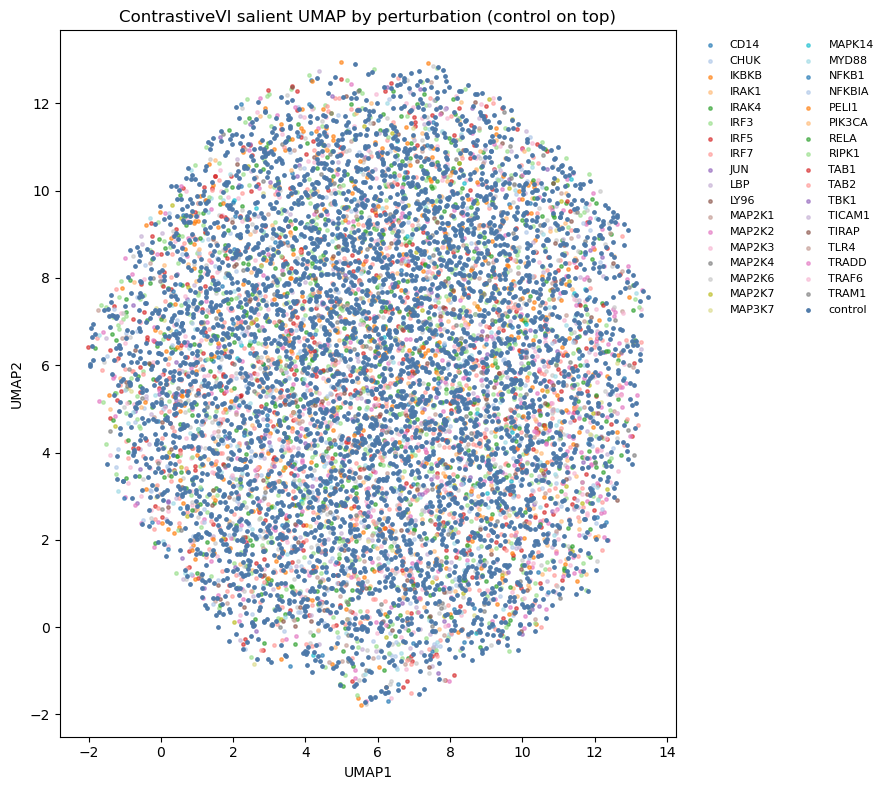

In [ ]:
# ContrastiveVI end-to-end: load -> map perturbations -> train -> UMAP -> plot (control on top)

from pathlib import Path
import re, numpy as np, pandas as pd
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import itertools

# ----------------------------- paths & knobs -----------------------------
P = Path("/Users/juliachen/Documents/AI4bio/UMAP/tumors/processed/finaltables")
COUNTS_CSV      = "matched_merfishcounttable_xy.csv"   # has: cell_id, X, Y, <genes...>
PERT_MATRIX_CSV = P / "tumorpooledperturbations.csv"       # pooled matrix with control row/col

N_SALIENT, N_BACKGROUND = 16, 10
EPOCHS = 600
N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.5
SPREAD = 2.0
RS = 0

OUT = Path("cvi_figs_global"); OUT.mkdir(exist_ok=True)

# ----------------------------- helpers -----------------------------
def get_latents(model, adata):
    """Version-safe latent extraction across scvi-tools 1.3.x–1.4.x."""
    if hasattr(model, "get_salient_representation"):
        Zs = model.get_salient_representation(adata=adata)
        Zb = model.get_background_representation(adata=adata)
    else:
        try:
            Zs = model.get_latent_representation(adata=adata, kind="salient")
            Zb = model.get_latent_representation(adata=adata, kind="background")
        except TypeError:
            # very old: single latent (treat as salient)
            Zs = model.get_latent_representation(adata)
            Zb = Zs
    return Zs, Zb

def detect_and_orient_pm(pm):
    """
    Ensure control is in the index (rows). If controls only appear as columns,
    transpose once. Return (pm_oriented, control_rows, gene_rows).
    """
    ctrl_re = re.compile(r"(?i)^(ctrl|control)$")
    # controls as rows?
    is_ctrl_row = pm.index.to_series().apply(lambda s: bool(ctrl_re.match(s)))
    ctrl_rows = pm.index[is_ctrl_row].tolist()
    # controls as columns?
    is_ctrl_col = pd.Series(pm.columns).apply(lambda s: bool(ctrl_re.match(str(s))))
    ctrl_cols = list(pd.Index(pm.columns)[is_ctrl_col.values])

    if not ctrl_rows and ctrl_cols:
        pm = pm.T.copy()
        # re-evaluate after transpose
        is_ctrl_row = pm.index.to_series().apply(lambda s: bool(ctrl_re.match(s)))
        ctrl_rows = pm.index[is_ctrl_row].tolist()

    if not ctrl_rows:
        raise RuntimeError("No exact 'control' (or 'ctrl') found in pooled matrix rows or columns.")

    gene_rows = [r for r in pm.index if r not in ctrl_rows]
    return pm, ctrl_rows, gene_rows

# ----------------------------- 1) load counts -----------------------------
df = pd.read_csv(COUNTS_CSV)
assert {"cell_id","X","Y"}.issubset(df.columns), "counts CSV must include cell_id, X, Y"

# everything except cell_id/X/Y are genes (counts)
num_cols = [c for c in df.columns if c not in {"cell_id","X","Y"}]
adata = sc.AnnData(df[num_cols].to_numpy())
adata.obs_names = df["cell_id"].astype(str).values
adata.var_names = num_cols
adata.obs["X"] = df["X"].values
adata.obs["Y"] = df["Y"].values
adata.layers["count"] = adata.X.copy()

# normalize obs names to uppercase (so c123 == C123)
adata.obs_names = pd.Index(adata.obs_names.astype(str).str.strip().str.upper())

print(f"adata shape: {adata.shape}")

# ----------------------------- 2) load perturbations & map labels -----------------------------
pm = pd.read_csv(PERT_MATRIX_CSV, index_col=0).apply(pd.to_numeric, errors="coerce").fillna(0.0)
pm.index = pm.index.astype(str).str.strip()
pm.columns = pm.columns.astype(str).str.strip().str.upper()   # normalize to match adata

# Orient so 'control' is in rows; get lists
pm, control_rows, gene_rows = detect_and_orient_pm(pm)

def label_for_cell(cid: str) -> str:
    """Return perturbation gene for this cell, or 'control', else 'unknown'."""
    if cid not in pm.columns:
        return "unknown"
    col = pm[cid]
    # prefer any gene row with >0
    if gene_rows:
        nzg = col.loc[gene_rows]
        nzg = nzg[nzg > 0]
        if len(nzg):
            return nzg.index[0]
    # else check control rows
    if control_rows and (col.loc[control_rows] > 0).any():
        return "control"
    return "unknown"

adata.obs["perturbation"] = pd.Categorical([label_for_cell(cid) for cid in adata.obs_names])

# Keep only control + genes defined in pooled matrix (drop unknowns)
valid = set(gene_rows) | {"control"}
keep_mask = adata.obs["perturbation"].isin(valid)
dropped = int((~keep_mask).sum())
if dropped:
    print(f"Dropping {dropped} cells with unknown mapping.")
adata = adata[keep_mask].copy()

counts = adata.obs["perturbation"].value_counts()
n_ctrl = int(counts.get("control", 0))
n_trt  = int(adata.n_obs - n_ctrl)
print("Counts per label:", counts.to_dict())
print(f"Control={n_ctrl}, Treated(total across genes)={n_trt}, Total={adata.n_obs}")

if n_ctrl == 0 or n_trt == 0:
    raise RuntimeError("No control or no treated cells after mapping. Check cell_id vs pooled matrix columns.")

# ----------------------------- 3) ContrastiveVI training (balanced & safe split) -----------------------------
# Keep raw counts in layer="count" for scvi; (optionally) add normalized copy to .raw for reference
sc.pp.normalize_total(adata, target_sum=1e4)  # for .raw / plots if needed
adata.raw = adata.copy()

# balanced indices
rng = np.random.default_rng(RS)
ctrl_all = np.where(adata.obs["perturbation"] == "control")[0]
trt_all  = np.where(adata.obs["perturbation"] != "control")[0]
m = min(len(ctrl_all), len(trt_all))
if m < 10:
    print(f"Warning: very small groups (min={m}). Disabling validation split.")
bg = rng.choice(ctrl_all, size=m, replace=False) if len(ctrl_all) > m else ctrl_all
tg = rng.choice(trt_all,  size=m, replace=False) if len(trt_all)  > m else trt_all
bg = np.sort(bg); tg = np.sort(tg)
print(f"Training with balanced sets: control={len(bg)} vs treated={len(tg)}")

TRAIN_SIZE = 1.0 if m < 10 else 0.9
VAL_SIZE   = None if m < 10 else 0.1

# set up & train
scvi.external.ContrastiveVI.setup_anndata(adata, layer="count")
model = scvi.external.ContrastiveVI(
    adata,
    n_salient_latent=N_SALIENT,
    n_background_latent=N_BACKGROUND,
    use_observed_lib_size=False,
)
train_kwargs = dict(
    background_indices=bg,
    target_indices=tg,
    max_epochs=EPOCHS,
    shuffle_set_split=True,
    early_stopping=True,
)
if VAL_SIZE is None:
    model.train(train_size=TRAIN_SIZE, **train_kwargs)
else:
    model.train(train_size=TRAIN_SIZE, validation_size=VAL_SIZE, **train_kwargs)

# ----------------------------- 4) Latent -> UMAP -----------------------------
Zs, Zb = get_latents(model, adata)
adata.obsm["X_salient"] = Zs
sc.pp.neighbors(adata, use_rep="X_salient", n_neighbors=N_NEIGHBORS, metric="cosine")
sc.tl.umap(adata, min_dist=UMAP_MIN_DIST, spread=SPREAD, random_state=RS)
coords = adata.obsm["X_umap"]

# ----------------------------- 5) Plot by perturbation (control on top) -----------------------------
plot_df = pd.DataFrame({
    "UMAP1": coords[:, 0],
    "UMAP2": coords[:, 1],
    "label": adata.obs["perturbation"].astype(str).values
})

# Legend order: control first, then other genes alphabetically
genes = sorted([g for g in plot_df["label"].unique() if g != "control"])
order = ["control"] + genes

# colors: explicit control color, cycle others so we never run out
color_map = {"control": "#4C78A8"}  # blue
palette = itertools.cycle(plt.cm.tab20.colors)
for g in genes:
    color_map[g] = next(palette)

plt.figure(figsize=(9, 8))
# non-controls first
for g in order:
    if g == "control": 
        continue
    sub = plot_df[plot_df["label"] == g]
    if not sub.empty:
        plt.scatter(sub["UMAP1"], sub["UMAP2"], s=6, alpha=0.6, color=color_map[g], label=g)
# control on top
sub = plot_df[plot_df["label"] == "control"]
if not sub.empty:
    plt.scatter(sub["UMAP1"], sub["UMAP2"], s=6, alpha=0.95, color=color_map["control"], label="control")

plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.title("ContrastiveVI salient UMAP by perturbation (control on top)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, fontsize=8, ncol=2)
plt.tight_layout()
plt.show()
# out_path = OUT / "cvi_umap_by_perturbation.png"
# plt.savefig(out_path, dpi=300)
# plt.close()
# print("Saved:", out_path.resolve())

perturbation counts: {'control': 4264, 'IRF3': 459, 'IRF5': 410, 'IRAK4': 398, 'IRF7': 330, 'MAP2K2': 325, 'MAP2K6': 311, 'MAP2K3': 247, 'PELI1': 223, 'LBP': 210, 'NFKBIA': 184, 'IRAK1': 179, 'TAB2': 167, 'RELA': 162, 'TRAM1': 156, 'MYD88': 148, 'IKBKB': 139, 'RIPK1': 128, 'TIRAP': 123, 'NFKB1': 113, 'CHUK': 95, 'MAP2K1': 85, 'JUN': 84, 'TLR4': 69, 'MAP2K7': 67, 'PIK3CA': 66, 'TRAF6': 63, 'CD14': 40, 'LY96': 33, 'TICAM1': 30, 'MAP3K7': 30, 'TRADD': 29, 'TBK1': 22, 'TAB1': 21, 'MAPK14': 20, 'MAP2K4': 2}


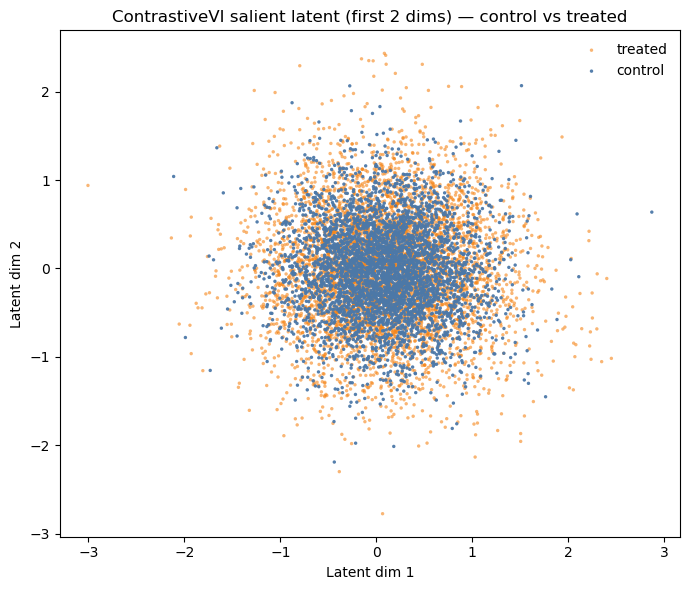

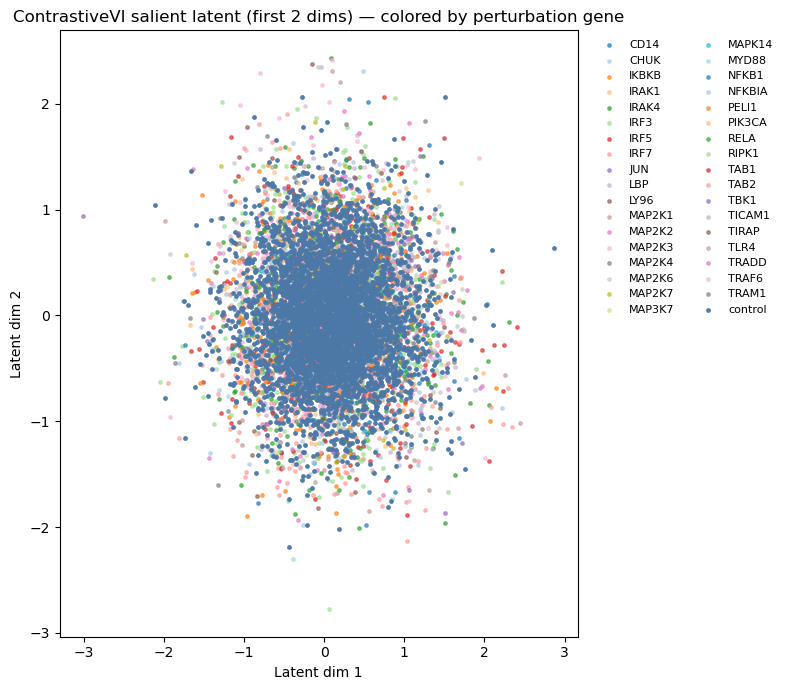

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Which labels do we actually have?
if "perturbation" not in adata.obs.columns:
    raise KeyError("Expected adata.obs['perturbation'] (gene names or 'control').")

print("perturbation counts:", adata.obs["perturbation"].value_counts().to_dict())

# Build a binary condition from perturbation
cond = np.where(adata.obs["perturbation"].astype(str).values == "control",
                "control", "treated")

# 2) Version-safe salient latent
def get_salient_latent(model, ad):
    if hasattr(model, "get_salient_representation"):
        return model.get_salient_representation(adata=ad)
    try:
        return model.get_latent_representation(adata=ad, kind="salient")
    except TypeError:
        return model.get_latent_representation(adata=ad)

Zs = get_salient_latent(model, adata)
adata.obsm["X_salient"] = Zs

# 3) Plot raw latent dims (no UMAP/PCA) — control vs treated
plt.figure(figsize=(7,6))
for g, color, alpha in [("treated", "#F58518", 0.6), ("control", "#4C78A8", 0.95)]:
    m = (cond == g)
    if m.any():
        plt.scatter(Zs[m,0], Zs[m,1], s=6, c=color, alpha=alpha, edgecolor="none", label=g)
plt.xlabel("Latent dim 1"); plt.ylabel("Latent dim 2")
plt.title("ContrastiveVI salient latent (first 2 dims) — control vs treated")
plt.legend(frameon=False); plt.tight_layout(); plt.show()

# 4) (Optional) color by perturbation gene instead of binary condition
# control on top, others underneath
labels = adata.obs["perturbation"].astype(str).values
genes = sorted([g for g in np.unique(labels) if g != "control"])
import itertools
color_map = {"control": "#4C78A8"}
for g, c in zip(genes, itertools.cycle(plt.cm.tab20.colors)):
    color_map[g] = c

plt.figure(figsize=(8,7))
# non-controls first
for g in genes:
    m = (labels == g)
    if m.any():
        plt.scatter(Zs[m,0], Zs[m,1], s=6, alpha=0.6, color=color_map[g], label=g)
# control on top
m = (labels == "control")
if m.any():
    plt.scatter(Zs[m,0], Zs[m,1], s=6, alpha=0.95, color=color_map["control"], label="control")
plt.xlabel("Latent dim 1"); plt.ylabel("Latent dim 2")
plt.title("ContrastiveVI salient latent (first 2 dims) — colored by perturbation gene")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", frameon=False, fontsize=8, ncol=2)
plt.tight_layout(); plt.show()

Explained variance (PC1, PC2): [0.0877 0.0817]


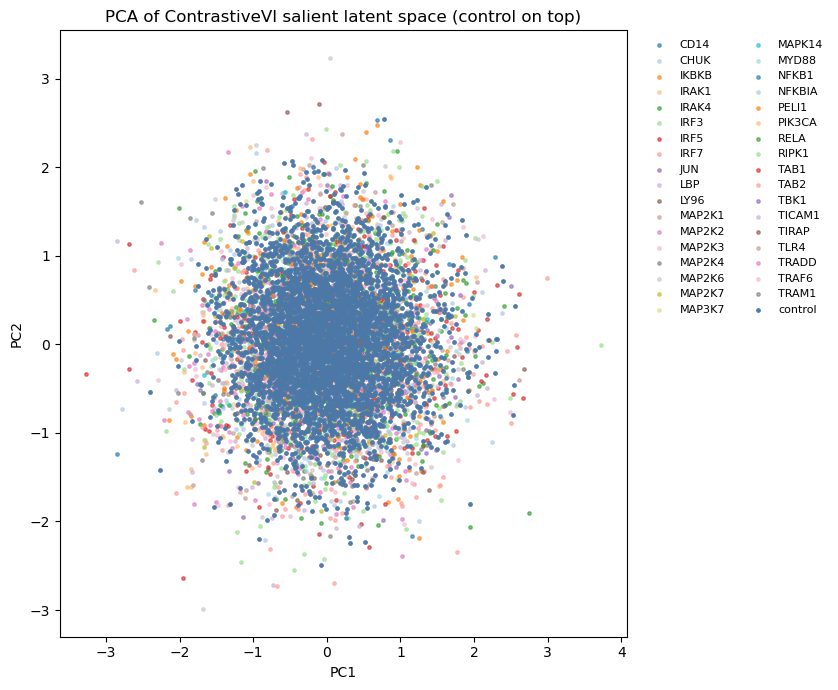

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# --- make sure the label column exists under a consistent name
if "perturb_gene" not in adata.obs.columns:
    if "perturbation" in adata.obs.columns:
        adata.obs["perturb_gene"] = adata.obs["perturbation"].astype(str)
    else:
        raise KeyError("Neither 'perturb_gene' nor 'perturbation' found in adata.obs")

# --- PCA on the salient latent space
Zs = adata.obsm["X_salient"]
pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(Zs)
adata.obsm["X_pca_salient"] = pcs
print("Explained variance (PC1, PC2):", np.round(pca.explained_variance_ratio_[:2], 4))

# --- plot: control first, then the others; control on top
labels = adata.obs["perturb_gene"].astype(str)
order = ["control"] + sorted([g for g in labels.unique() if g != "control"])

# color map (control fixed color, others cycling)
import itertools
color_map = {"control": "#4C78A8"}
palette = itertools.cycle(plt.cm.tab20.colors)
for g in order:
    if g != "control" and g not in color_map:
        color_map[g] = next(palette)

plt.figure(figsize=(8.5,7))
# non-controls first
for g in order:
    if g == "control":
        continue
    mask = (labels == g).values
    if mask.any():
        plt.scatter(pcs[mask,0], pcs[mask,1], s=6, alpha=0.6, color=color_map[g], label=g)
# control on top
mask = (labels == "control").values
if mask.any():
    plt.scatter(pcs[mask,0], pcs[mask,1], s=6, alpha=0.95, color=color_map["control"], label="control")

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA of ContrastiveVI salient latent space (control on top)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", frameon=False, fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


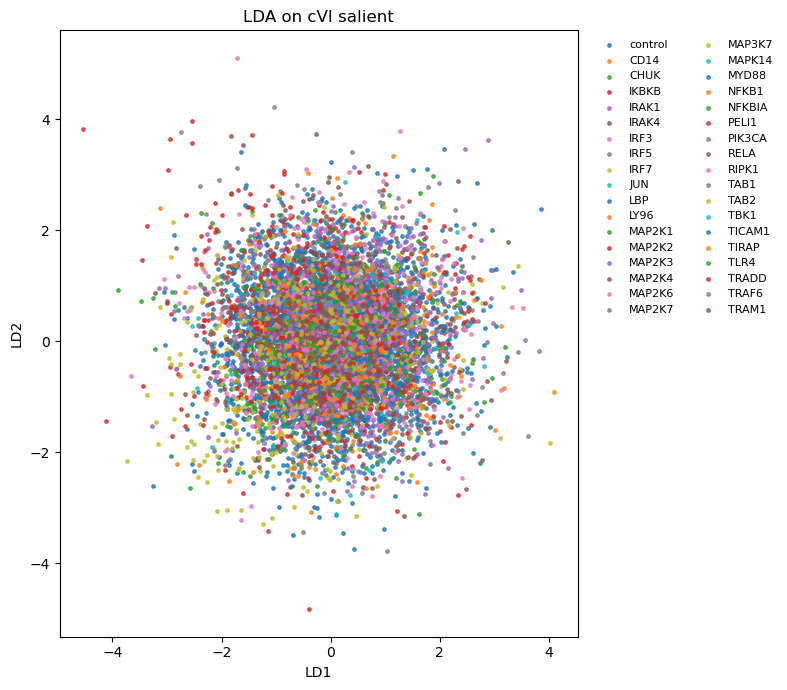

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Z = adata.obsm["X_salient"]
y = (adata.obs["perturb_gene"]
     if "perturb_gene" in adata.obs
     else adata.obs["perturbation"]).astype(str).values

lda = LDA(n_components=2)
Z_lda = lda.fit_transform(Z, y)

plt.figure(figsize=(8,7))
for g in ["control"] + sorted([x for x in np.unique(y) if x!="control"]):
    m = (y==g)
    plt.scatter(Z_lda[m,0], (Z_lda[m,1] if Z_lda.shape[1]>1 else np.zeros(m.sum())),
                s=6, alpha=0.75, label=g)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", frameon=False, fontsize=8, ncol=2)
plt.xlabel("LD1"); plt.ylabel("LD2" if Z_lda.shape[1]>1 else ""); plt.title("LDA on cVI salient")
plt.tight_layout(); plt.show()


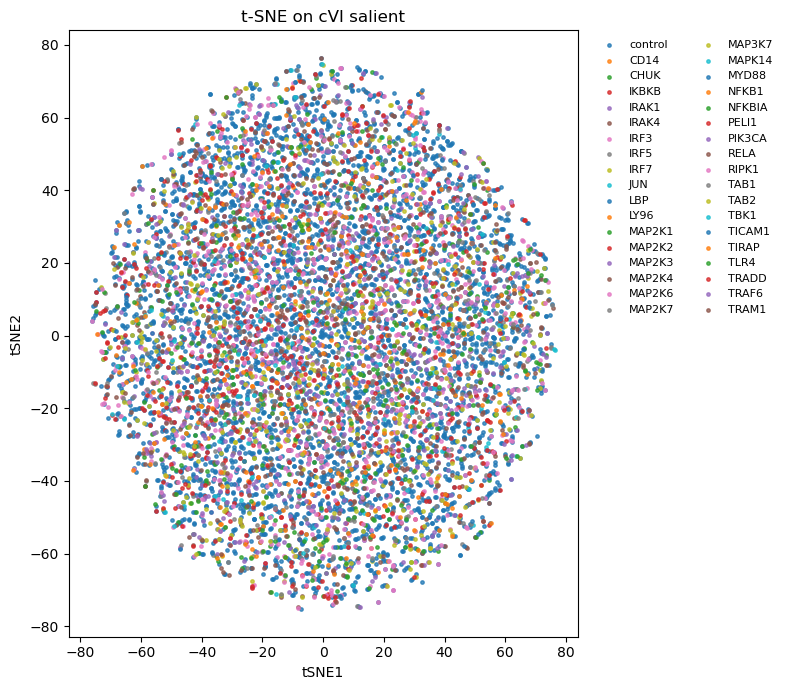

In [ ]:
from sklearn.manifold import TSNE
Z = adata.obsm["X_salient"]
y = (adata.obs["perturb_gene"] if "perturb_gene" in adata.obs else adata.obs["perturbation"]).astype(str).values

ts = TSNE(n_components=2, perplexity=30, learning_rate=200, metric="cosine", random_state=0)
T = ts.fit_transform(Z)

plt.figure(figsize=(8,7))
for g in ["control"] + sorted([x for x in np.unique(y) if x!="control"]):
    m = (y==g)
    plt.scatter(T[m,0], T[m,1], s=6, alpha=0.75, label=g)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", frameon=False, fontsize=8, ncol=2)
plt.xlabel("tSNE1"); plt.ylabel("tSNE2"); plt.title("t-SNE on cVI salient")
plt.tight_layout(); plt.show()